  Machine learning techniques for brain tumor detection   
Members :  
- CORDINA Emmanuel  
- HUILLET Thibault  
- RADJOU Aditya

# Importing Data and Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.utils import Bunch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import time
import numpy as np
from math import exp
from scipy.stats import logistic
!pip install ipython-autotime
%load_ext autotime



#path to the project
#path = "/content/drive/MyDrive/"
path="/content/drive/MyDrive/Colab_Notebooks/archive/"
cote=256
dim=(cote,cote)
#First we need to load the different datasets with the different types of tumor
cancerType=["no_tumor","glioma_tumor","meningioma_tumor","pituitary_tumor"]
data_cancer_type1_List =  os.listdir(path+cancerType[1])
data_cancer_type2_List =  os.listdir(path+cancerType[2])
data_cancer_type3_List =  os.listdir(path+cancerType[3])
data_no_cancer_List = os.listdir(path+cancerType[0])
data_cancer=[data_no_cancer_List,data_cancer_type1_List,data_cancer_type2_List,data_cancer_type3_List]

data=[]
target=[]
i=0
label=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]

for cancerData in data_cancer:
  for img in cancerData:
      img_path=path+cancerType[i]+"/"+img
      img_cv2=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      img_resized=cv2.resize(img_cv2,dim)
      data.append(img_resized)
      target.append(label[i])
  i+=1
  
dataset=Bunch(data=data,target=target)
shuffle=np.random.permutation(range(len(dataset.data)))
X = np.array(dataset.data)[shuffle,:]
y = np.array(dataset.target)
y=y[shuffle]


x_train=X
y_train=y
X_train=x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))

#checking the shape after reshaping
print("Shape of X_train :", X_train.shape)
print(X_train.shape[0])

#normalizing the pixel values
X_train=X_train/255
X_train_NN = []
for x in X_train:
  X_train_NN.append(x.flatten())
X_train_NN=np.array(X_train_NN)
Y_train_NN = np.eye(2)[y_train,:]
X_test_NN = X_train_NN[180:,:]
Y_test_NN = Y_train_NN[180:,:]
X_train_NN = X_train_NN[0:180,:]
Y_train_NN = Y_train_NN[0:180,:]





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of X_train : (3274, 256, 256, 1)
3274
time: 22.1 s (started: 2022-01-20 23:06:22 +00:00)


In [6]:
y_train.shape

(3274, 4)

time: 4.47 ms (started: 2022-01-20 20:33:23 +00:00)


# Implementing NN from Lab 2


In [1]:

class Layer:
    '''
    The class Layer contains the parameters of each layer. Its initialization make them all empty
    '''
    def __init__(self):
        self.W=[] # self.W = the incoming weights
        self.b=[] # self.b = the biases
        self.a=[] # self.a = the activations
        self.z=[] # self.z = the outputs
        self.d_W=[] # self.d_W = the gradient of the incoming weights
        self.d_b=[] # self.d_b = the gradient of the biases
        self.d_a=[] # self.d_a = the gradient of the activations
        self.d_z=[] # self.d_z = the gradient of the outputs

class MLP(Layer): # Multi Layer Perceptron
    def __init__(self, neurons_per_layer):
        '''
        Create the weight matrices for each layer following the neurons_per_layer vector.
        It initializes also the loss and accuracy vector
        
        self.layer[0].W contains the weights which connect input layer 1 with 1st hidden layer. Dimensions [n_1st,n_input]
        self.layer[0].b contains the biases of 1st hidden layer
        self.layer[0].a contains the activation of 1st hidden layer
        self.layer[0].z contains the outputs of 1st hidden layer
        self.layer[0].d_W contains the derivative of loss w.r.t the weights which connect input layer 1 with 1st hidden layer. Dimensions [n_1st,n_input]
        self.layer[0].d_b contains the derivative of loss w.r.t the biases of 1st hidden layer
        self.layer[0].d_a contains the derivative of loss w.r.t the activations of 1st hidden layer
        self.layer[0].d_z contains the derivative of loss w.r.t the outputs of 1st hidden layer
        self.layer[1].W contains the weights which connect 1st hidden layer with 2nd hidden layer. Dimensions [n_2nd,n_1st]
        self.layer[1].b contains the biases of 2nd hidden layer
        ecc...
        self.weights[n] contains the weights which connect nth hidden layer with output layer. Dimensions Dimensions [n_nth,n_output]
        self.biases[n] contains the biases of output layer
        ...
        
        INPUT : 
        - neurons_per_layer : numpy array containing the number of neurons in
            [ input layer, hidden layer1, hidden layer 2, ..., output layer ]
        '''
        super().__init__()
        
        self.layer={}
        
        for i in range(0,len(neurons_per_layer)-1) :
            self.layer[i]=Layer()
            self.layer[i].W=(10**(-1))*np.random.randn(neurons_per_layer[i+1],neurons_per_layer[i])
            self.layer[i].b=np.zeros((1,neurons_per_layer[i+1]))
            self.layer[i].a=np.zeros((1,neurons_per_layer[i+1])) 
            self.layer[i].z=np.zeros((1,neurons_per_layer[i+1]))
            self.layer[i].d_W=np.zeros((neurons_per_layer[i+1],neurons_per_layer[i]))
            self.layer[i].d_b=np.zeros((1,neurons_per_layer[i+1])) 
            self.layer[i].d_a=np.zeros((1,neurons_per_layer[i+1]))
            self.layer[i].d_z=np.zeros((1,neurons_per_layer[i+1]))

        
        self.losses=[]
        self.accuracies=[]
        
    def sigmoid(a) :
        '''
        Sigmoid activation function. It can work with single inputs or vectors or matrices.
        '''
        # logistic.cdf from scipy is used for stability instead of exponential functions
        
        return np.array(logistic.cdf(a)) 
    
    def d_sigmoid(a) :
        '''
        Derivative of sigmoid activation function. It can work with single inputs or vectors or matrices.
        '''
        # use MLP.sigmoid() to generate the derivative sigmoid function
        
        ################# YOUR CODE HERE ####################
        
        pass
    
        ################ END OF YOUR CODE HERE ##############
    
    def forward(self, x) :
        '''
        Forward function. From input layer to output layer. Input can be 1D or 2D.
        
        INPUTS:
        - x : numpy array of size NxD, where N is the number of samples, D is the number of input dimensions referred as n_input before
        
        OUTPUTS:
        - y_hat : numpy array of size NxC, where C is the number of classes
        '''
        
        # write a function which performs the forward operation
        # remember you have len(self.layers) number of layers
        # and each layer has its own parameters:
        # self.layer[0].W are the weights between input and 1st hidden layer
        # self.layer[0].b are the biases of the 1st hidden layer
        # ...
        
        ################# YOUR CODE HERE ####################
        
        pass
        
        ################ END OF YOUR CODE HERE ##############

    
    def loss(y_hat, y) :
        '''
        Compute the loss between y_hat and y! they can be 1D or 2D arrays!
        
        INPUTS:
        - y_hat : numpy array of size NxC, N number of samples, C number of classes. It contains the estimated values of y
        - y : numpy array of size NxC with one 1 in each row, corresponding to the correct class for that sample
        
        OUTPUTS:
        - L : MSE loss
        '''
        
        # compute the mean square loss between y_hat and y
        
        ################# YOUR CODE HERE ####################
        
        pass
        
        ################ END OF YOUR CODE HERE ##############
        
    
    def accuracy(y_hat,y) :
        '''
        Compute the accuracy between y_hat and y
        
        INPUTS:
        - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
        - y : numpy array of size NxC with correct values of y
        
        OUTPUTS:
        - accuracy
        '''
        
        # compute the accuracy counting how many y_hat are equal to y
        # over the total number of N samples
        # accuracy is a value in [0,1]
        
        ################# YOUR CODE HERE ####################
        
        pass
        
        ################ END OF YOUR CODE HERE ##############
        
    
    def backpropagation(self,x,y,y_hat,learning_rate) :
        '''
        Backpropagate the error from last layer to input layer and then update the parameters
        
        INPUTS:
        - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
        -y : numpy array of size NxC with correct values of y
        
        OUTPUTS: (compute the error at the different levels and for each layer)
        - d_a
        - d_z
        - delta_L
        - delta_l
        - d_W
        - d_b
        '''
    # compute gradients
        # suggestion compute first the derivatives of elements in final layer,
        # then iterate from the last hidden layers to the second (NOT the first) and compute the derivatives
        # then compute the derivatives in the first hidden layer
    
        ################# YOUR CODE HERE ####################
        
        pass
        
        ################ END OF YOUR CODE HERE ##############

    # apply gradients
        # just one for loop passing through all layers is sufficient
        # apply the gradients only to self.layer[i].b and self.layer[i].W
    
        ################# YOUR CODE HERE ####################
        

        ################ END OF YOUR CODE HERE ##############
        
    def training(self,x,y,learning_rate,num_epochs,verbose=False, print_every_k=1) :
        '''
        Training your network
        
        INPUTS:
        - x : numpy array of size NxD, D number of features of your input
        - y : numpy array of size NxC, C number of classes, with correct values of target
        - learning_rate : a numpy scalar containing your learning rate
        - num_epochs : a numpy scalar representing the number of epochs with which train your networks
        - verbose : a boolean False by default, if True print the training loss and training accuracy values
                    if False only store them
        - print_every_k : a numpy scalar equal 1 by default, if verbose is True print the result every print_every_k epochs

        OUTPUTS: /
        '''
        accuracy=[]
        loss=[]

        # iterate for num_epochs number of epochs
        for epoch in range(num_epochs) :
            
            # shuffle your training set
            shuffle=np.random.permutation(range(x.shape[0]))
            x_shuffled=x[shuffle,:]
            y_shuffled=y[shuffle,:]
            # sample by sample forward and backward through the network using stochastic gradient descent (SGD)
            for sample in range(x.shape[0]) :
                y_hat=self.forward(x_shuffled[sample,:])
                self.backpropagation(x_shuffled[sample,:].reshape(1,x.shape[1]),y_shuffled[sample,:],y_hat,learning_rate)

        # check how is performing the network after each epoch
            # estimate the training labels
            Y_hat=self.forward(x)
            # compute the loss
            loss.append(MLP.loss(Y_hat,y))
            # compute the accuracy
            accuracy.append(MLP.accuracy(Y_hat,y))
            
            # if verbose is True print the results every print_every_k
            if ((verbose == True) and (epoch%print_every_k==0)):
                print('Epoch %d : loss = %.5e, accuracy = %.2f %%' %(epoch,loss[epoch],100*accuracy[epoch]))
               

        self.losses=loss
        self.accuracies=accuracy

def d_sigmoid(a) :
    '''
    Derivative of sigmoid activation function. It can work with single inputs or vectors or matrices.
    Return the sigmoid derivative of a
    '''
    ################# YOUR CODE HERE ####################

    return MLP.sigmoid(a)*(1-MLP.sigmoid(a))
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.d_sigmoid=d_sigmoid
def forward(self, x) :
    '''
    Forward function. From input layer to output layer. Input can handle 1D or 2D inputs.

    INPUTS:
    - x : numpy array of size NxD, where N is the number of samples, D is the number of input dimensions referred as n_input before

    OUTPUTS:
    - y_hat : numpy array of size NxC, where C is the number of classes
    '''
    ################# YOUR CODE HERE ####################
    n = len(self.layer)
    
    # forward propagation between the input layer and the first layer
    self.layer[0].a = np.dot(x,self.layer[0].W.T) + self.layer[0].b
    self.layer[0].z = MLP.sigmoid(self.layer[0].a)
    
    # forward propagation between the layers and the output layer
    for i in range(1,n):
        self.layer[i].a = np.dot(self.layer[i-1].z,self.layer[i].W.T) + self.layer[i].b
        self.layer[i].z = MLP.sigmoid(self.layer[i].a)
    y_hat=self.layer[len(self.layer)-1].z 


    # binarizing y_hat
    for j in range(len(y_hat)):
            y_hat[j]=y_hat[j]/max(y_hat[j])   
    y_hat=(y_hat==1).astype(int)       #y_hat is has one 1 in each row (otherwise it is 0), corresponding to the most frequent class
    
    ################ END OF YOUR CODE HERE ##############

    return y_hat

MLP.forward=forward
def loss(y_hat, y) :
    '''
    Compute the loss between y_hat and y! they can be 1D or 2D arrays!

    INPUTS:
    - y_hat : numpy array of size NxC, N number of samples, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with one 1 in each row, corresponding to the correct class for that sample

    OUTPUTS:
    - L : MSE loss
    '''
    ################# YOUR CODE HERE ####################

    N = y_hat.shape[0]
    
    L=0
    for n in range(N):
        for k in range(y_hat.shape[1]):
            L+=(y_hat[n][k]-y[n][k])**2

    ################ END OF YOUR CODE HERE ##############

    return L/(2*N)

MLP.loss=loss
def accuracy(y_hat,y) :
    '''
    Compute the accuracy between y_hat and y

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with correct values of y

    OUTPUTS:
    - acc : the accuracy value between 0 and 1
    '''
    ################# YOUR CODE HERE ####################

    acc=np.sum(y_hat==y)/(len(y[0])*len(y))

    ################ END OF YOUR CODE HERE ##############

    return acc

MLP.accuracy=accuracy
def backpropagation(self,x,y,y_hat,learning_rate) :
    '''
    Backpropagate the error from last layer to input layer and then update the parameters

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    -y : numpy array of size NxC with correct values of y

    OUTPUTS: (compute the error at the different levels and for each layer)
    - d_a
    - d_z
    - delta_L
    - delta_l
    - d_W
    - d_b
    '''
# compute gradients

    ################# YOUR CODE HERE ####################
    N=len(self.layer)

    delta_L=y_hat-y
    self.layer[N-1].d_z=delta_L
    self.layer[N-1].d_a=delta_L*MLP.d_sigmoid(self.layer[N-1].a) #activations
    self.layer[N-1].d_b=self.layer[N-1].d_a #biais
    self.layer[N-1].d_W=np.dot(self.layer[N-1].d_a.T,self.layer[N-2].z) 

    for l in range(N-2,-1-1):
        delta_l=np.dot(self.layer[l+1].d_a,self.layer[l+1].W)
        self.layer[l].d_z=delta_l #outputs
        self.layer[l].d_a=delta_l*MLP.d_sigmoid(self.layer[l].a) #activations
        self.layer[l].d_b=self.layer[l].d_a #biais
        self.layer[l].d_W=np.dot(self.layer[l].d_a.T,self.layer[l-1].z) #weights
    
    ################ END OF YOUR CODE HERE ##############

# apply gradients
    # just one for loop passing through all layers is sufficient
    # apply the gradients only to self.layer[i].b and self.layer[i].W

    ################# YOUR CODE HERE ####################
    
    for i in range(N):
        self.layer[i].b=self.layer[i].b-learning_rate*self.layer[i].d_b
        self.layer[i].W=self.layer[i].W-learning_rate*self.layer[i].d_W
        
    return None
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.backpropagation=backpropagation


            

TRAINING
Epoch 0 : loss = 3.00000e-01, accuracy = 70.00 %
Epoch 5 : loss = 2.50000e-01, accuracy = 75.00 %
Epoch 10 : loss = 2.22222e-01, accuracy = 77.78 %
Epoch 15 : loss = 1.94444e-01, accuracy = 80.56 %
Epoch 20 : loss = 2.16667e-01, accuracy = 78.33 %
Epoch 25 : loss = 1.72222e-01, accuracy = 82.78 %
Epoch 30 : loss = 1.61111e-01, accuracy = 83.89 %
Epoch 35 : loss = 1.44444e-01, accuracy = 85.56 %
Epoch 40 : loss = 1.50000e-01, accuracy = 85.00 %
Epoch 45 : loss = 1.38889e-01, accuracy = 86.11 %
final : loss = 1.333e-01 , accuracy = 86.67 %

TEST
loss = 2.877e-01 , accuracy = 71.23 %



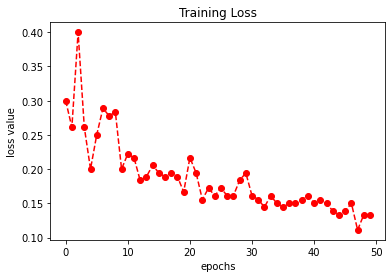

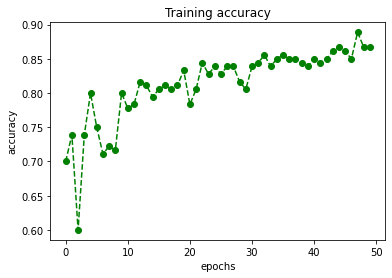

time: 47min (started: 2022-01-20 16:00:52 +00:00)


In [ ]:

# Neural Network (NN) parameters
epochs=50  
learning_rate=0.02
verbose=True
print_every_k=5

# Initialization of the NN
NN1 = MLP([128*128, 64*64, 1])
print('TRAINING')
# Training
NN1.training(X_train_NN,Y_train_NN,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(X_train_NN)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,Y_train_NN),100*MLP.accuracy(y_hat,Y_train_NN)))

# Test
print('\nTEST')
y_hat=NN1.forward(X_test_NN)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,Y_test_NN),100*MLP.accuracy(y_hat,Y_test_NN)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

This implementation is really slow because we have to flatten a 128x128 images that we feed in the Neural Network. This means we have 128x128 = 16 384 to minimize juste for the first layer. Even if we use a 1 hidden layer with 64x64 = 4096 weights, we have around 20 000 parameters to optimize which is enormous
However, it gives pretty good results, but it is too slow to be used. (Around 45 min for that neural network, especially because we implemented it and didn't use tensorflow)\
I would probably be as slow for KNN or linear Regression.
We need to change our methods to adapt to the image properties of the input. \\
Litterature on Neural Networks tells us that Convolutionnal Neural Network could be a solution.

# Implementing 2D-CNN

In [2]:
#importing the required libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


time: 7.28 s (started: 2022-01-20 23:07:15 +00:00)


Epoch 1/20
62/62 [==============================] - 606s 10s/step - loss: 9.1332 - accuracy: 0.4817 - val_loss: 6.9059 - val_accuracy: 0.4473
Epoch 2/20
62/62 [==============================] - 610s 10s/step - loss: 5.4589 - accuracy: 0.5570 - val_loss: 4.3495 - val_accuracy: 0.6023
Epoch 3/20
62/62 [==============================] - 614s 10s/step - loss: 3.6256 - accuracy: 0.6293 - val_loss: 3.0773 - val_accuracy: 0.6450
Epoch 4/20
62/62 [==============================] - 616s 10s/step - loss: 2.6998 - accuracy: 0.6802 - val_loss: 2.4534 - val_accuracy: 0.6885
Epoch 5/20
62/62 [==============================] - 613s 10s/step - loss: 2.2175 - accuracy: 0.7276 - val_loss: 2.1537 - val_accuracy: 0.6802
Epoch 6/20
62/62 [==============================] - 616s 10s/step - loss: 1.9491 - accuracy: 0.7434 - val_loss: 1.9457 - val_accuracy: 0.7183
Epoch 7/20
62/62 [==============================] - 610s 10s/step - loss: 1.7803 - accuracy: 0.7581 - val_loss: 1.8981 - val_accuracy: 0.6634
Epoch 

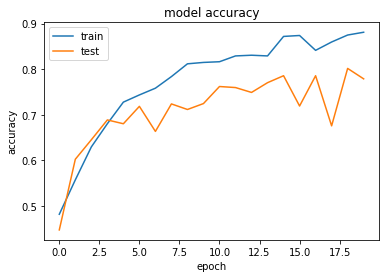

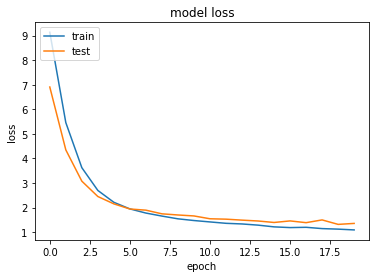

time: 3h 23min 26s (started: 2022-01-20 23:07:28 +00:00)


In [3]:
#initial_learning_rate = 0.1
#decay_steps = 1.0
#decay_rate = 0.5
#learning_rate_fn = schedules.InverseTimeDecay(
#  initial_learning_rate, decay_steps, decay_rate)
#We could use an adaptative learning rate
learning_rate_fn= 10**-5

#defining model
model=Sequential()
#adding convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(cote,cote,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
#adding pooling layer
model.add(MaxPool2D(2,2))
#adding fully connected layer
model.add(Flatten())
model.add(Dense(100,activation='relu', kernel_regularizer=l2(0.05)))
#adding output layer
model.add(Dense(4,activation='relu', kernel_regularizer=l2(0.05)))
#compiling the model
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate_fn),metrics=['accuracy'])
#fitting the model
history = model.fit(X_train,y_train,validation_split=0.4,epochs=20)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

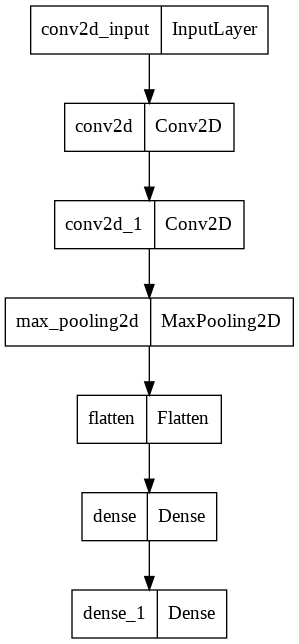

time: 917 ms (started: 2022-01-21 02:31:11 +00:00)


In [4]:
from tensorflow.keras.utils import plot_model
plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)